<a href="https://colab.research.google.com/github/KamonohashiPerry/MachineLearning/blob/master/deep-learning-from-scratch-2/Chapter3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# word2vec

## 推論ベースの手法とニューラルネットワーク

### カウントベース手法の問題点
+ 一度にまとめて学習データを処理するので、語彙数が大きい場合に計算量が膨大になる。
+ 推論ベースの手法であれば、ミニバッチで処理することも可能で、並列処理も可能。

### 推論ベースの手法の概要
+ 周囲の単語（コンテキスト）が与えられたときに、次にどのような単語が出現するのかを推測する。

### ニューラルネットワークにおける単語の処理方法
+ one-hot表現

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 入力
W = np.random.randn(7, 3) # 重み
h = np.dot(c, W) # 中間ノード
print(h)

[[-1.09936032  0.74894757  0.04970582]]


MatMulレイヤでも同様のことができる。

In [0]:
class MatMul:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.x = None

  def forward(self, x):
    W, = self.params
    out = np.dot(x, W)
    self.x = x
    return out

  def backward(self, dout):
    W, = self.params
    dx = np.dot(dout, W.T)
    dW = np.dot(self.x.T, dout)
    self.grads[0][...] = dW
    return dx

In [3]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 入力
W = np.random.randn(7, 3) # 重み
layer = MatMul(W)
h = layer.forward(c) # 中間ノード
print(h)

[[-0.16878773 -1.18851534 -1.08279688]]


## シンプルなword2vec
+ continuous bag-of-words(CBOW)

### CBOWモデルの推論処理
+ コンテキストからターゲットを推測することを目的としたニューラルネットワーク
+ 正確な推測ができるように訓練することで、単語の分散表現を獲得することができる。

中間層のニューロンの数を入力層のそれよりも減らすことが重要なポイント

In [4]:
# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5*(h0 + h1)
s = out_layer.forward(h)

print(s)

[[-0.74892782 -1.45464308  0.87389558 -1.61871238 -1.14947094 -0.58422913
   0.7730537 ]]


### CBOWモデルの学習
+ CBOWモデルの学習で行うことは正しい予測ができるように重みを調整すること
+ 実際のモデルは多クラス分類を行うニューラルネットワーク
  + それを学習するためにSoftmaxと交差エントロピー誤差を用いる

### word2vecの重みと分散表現
+ word2vecで使用されるネットワークの2つの重み
 + 入力側の全結合層の重み
 + 出力側の全結合層の重み

+ A. 入力側の重みだけを利用する
+ B. 出力側の重みだけを利用する
+ C. 2つの重みの両方を利用する

Aが一番ポピュラー

## 学習データの準備

### コンテキストとターゲット

In [0]:
def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')

  word_to_id = {}
  id_to_word = {}
  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word

  corpus = np.array([word_to_id[w] for w in words])

  return corpus, word_to_id, id_to_word

In [0]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

In [7]:
print(corpus)

[0 1 2 3 4 1 5 6]


In [8]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [0]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []

  for idx in range(window_size, len(corpus) - window_size):
    cs = []
    for t in range(-window_size, window_size + 1):
      if t == 0:
        continue
      cs.append(corpus[idx + t])
    contexts.append(cs)

  return np.array(contexts), np.array(target)

In [10]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [11]:
print(target)

[1 2 3 4 1 5]


### one-hot表現への変換

In [0]:
# one-hot表現への変換
def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換
    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]

    if corpus.ndim ==1:
      one_hot = np.zeros((N, vocab_size), dtype=np.int32)
      for idx, word_id in enumerate(corpus):
        one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
      C = corpus.shape[1]
      one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
      for idx_0, word_ids in enumerate(corpus):
        for idx_1, word_id in enumerate(word_ids):
          one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [0]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

これで学習データの準備ができた

## CBOWモデルの実装

In [0]:
def softmax(x):
  if x.ndim == 2:
    x = x - x.max(axis=1, keepdims=True)
    x = np.exp(x)
    x /= x.sum(axis=1, keepdims=True)
  elif x.ndim == 1:
    x = x - np.max(x)
    x = np.exp(x) / np.sum(np.exp(x))
  
  return x

def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
  if t.size == y.size:
    t = t.argmax(axis=1)

  batch_size = y.shape[0]

  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class SoftmaxWithLoss:
  def __init__(self):
    self.params, self.grads = [], []
    self.y = None # softmaxの出力
    self.t = None # 教師ラベル

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)

    # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
    if self.t.size == self.y.size:
      self.t = self.t.argmax(axis=1)

    loss = cross_entropy_error(self.y, self.t)
    return loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]

    dx = self.y.copy()
    dx[np.arange(batch_size), self.t] -= 1
    dx *= dout
    dx = dx / batch_size

    return dx

In [0]:
class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size

    # 重みの初期化
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(H, V).astype('f')

    # レイヤの生成
    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()

    # すべての重みと勾配をリストにまとめる
    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # メンバ変数に単語の分散表現を設定
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0 + h1)*0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss

  def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

### 学習コードの実装


In [0]:
import time
import matplotlib.pyplot as plt
import numpy as np

def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]

    while True:
      find_flg = False
      L = len(params)

      for i in range(0, L - 1):
        for j in range(i + 1, L):
          # 重みを共有する場合
          if params[i] is params[j]:
            grads[i] += grads[j] # 勾配の加算
            find_flg = True
            params.pop(j)
            grads.pop(j)
          # 転置行列として重みを共有する場合
          elif params[i].ndim == 2 and params[j].ndim == 2 \
              and params[i].T.shape == params[j].shape \
              and np.all(params[i].T == params[j]):
            grads[i] += grads[j].T
            find_flg = True
            params.pop(j)
            grads.pop(j)

          if find_flg:
            break

        if find_flg:
          break

      if not find_flg:
        break

    return params, grads


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


class Trainer:
  def __init__(self, model, optimizer):
    self.model = model
    self.optimizer = optimizer
    self.loss_list = []
    self.eval_interval = None
    self.current_epoch = 0

  def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None,eval_interval=20):
    data_size = len(x)
    max_iters = data_size // batch_size
    self.eval_interval = eval_interval
    model, optimizer = self.model, self.optimizer
    total_loss = 0
    loss_count = 0

    start_time = time.time()
    for epoch in range(max_epoch):
      # シャッフル
      idx = np.random.permutation(np.arange(data_size))
      x = x[idx]
      t = t[idx]

      for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        params, grads = remove_duplicate(model.params, model.grads) # 共有された重みを1つに集約

        if max_grad is not None:
          clip_grads(grads, max_grad)
        optimizer.update(params, grads)
        total_loss += loss
        loss_count += 1

        # 評価
        if (eval_interval is not None) and (iters % eval_interval) == 0:
          avg_loss = total_loss / loss_count
          elapsed_time = time.time() - start_time
          print('| epoch %d | iter %d / %d | time %d[s] | loss %.2f' % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
          self.loss_list.append(float(avg_loss))
          total_loss, loss_count = 0, 0

      self.current_epoch += 1

  def plot(self, ylim=None):
      x = np.arange(len(self.loss_list))
      if ylim is not None:
        plt.ylim(*ylim)
      plt.plot(x, self.loss_list, label='train')
      plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
      plt.ylabel('loss')
      plt.show()

In [0]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
      self.lr = lr
      self.beta1 = beta1
      self.beta2 = beta2
      self.iter = 0
      self.m = None
      self.v = None

    def update(self, params, grads):
      if self.m is None:
        self.m, self.v = [], []
        for param in params:
          self.m.append(np.zeros_like(param))
          self.v.append(np.zeros_like(param))

      self.iter += 1
      lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

      for i in range(len(params)):
        self.m[i] += (1 - self.beta1)*(grads[i] - self.m[i])
        self.v[i] += (1 - self.beta2)*(grads[i]**2 - self.v[i])

        params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7 )

| epoch 1 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 | iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 | iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 | iter 1 / 2 | time 0[s] | loss 1.94
|

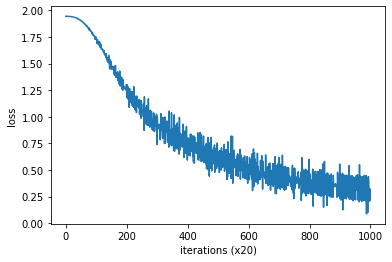

In [26]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [19]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [ 1.1442375 -1.0848508  1.2020551 -1.1998441 -1.2708226]
say [-0.40530145  1.2568203  -0.19585778  1.2507315   1.2313296 ]
goodbye [ 0.7555472 -0.9368341  0.7168187 -0.7766382 -0.6685878]
and [-1.5760317  1.018512  -1.6207739  1.0472741  1.0153848]
i [ 0.770731   -0.9386165   0.72229666 -0.80146235 -0.6858234 ]
hello [ 1.1474267 -1.0928493  1.1948998 -1.1817892 -1.2732341]
. [1.5669074 1.0647292 1.510338  1.0848185 1.0930442]


## word2vecに関する補足

### CBOWモデルと確率
モデル
$$P(w_t | w_{t-1}, w_{t+1})$$

損失関数
$$L = -log P(w_t | w_{t-1}, w_{t+1})$$

コーパス全体に拡張した損失関数
$$L = - \frac{1}{T} \sum ^T _{t=1} log P(w_t | w_{t-1}, w_{t+1}) $$

CBOWモデルの学習を行うとは、この式の損失関数を最小化させることに他ならない。

その際の重みパラメータが単語の分散表現となる。

### skip-gramモデル
skip-gramはCBOWで扱うコンテキストとターゲットを逆転させたモデル。中央の単語(ターゲット)から、周囲の複数ある単語(コンテキスト)を推測する。

モデル
$$ P(w_{t-1},w_{t+1}|w_t) $$

$$P(w_{t-1}, w_{t+1} | w_t) = P(w_{t-1}|w_t)P(w_{t+1}|w_t)$$

$$L = -log P(w_{t-1},w_{t+1}|w_t) \\
= -log P(w_{t-1}|w_t)P(w_{t+1}|w_t) \\
= -( log P(w_{t-1}|w_t) + log P(w_{t+1}|w_t) ) $$

損失関数
$$L= - \frac{1}{T}\sum^T_{t=1}( log P(w_{t-1}|w_t) + log P(w_{t+1}|w_t) )$$


多くの場合、skip-gramのほうが良い結果が得られる。  
コーパスが大規模になるにつれて、低頻出の単語や類推問題の性能の点においてskip-gramのほうが良い結果が得られる。

ただし、計算コストはCBOWの方が低い。

In [0]:
# skip-gramの実装
class SimpleSkipGram:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size

    # 重みの初期化
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(H, V).astype('f')

    # レイヤの生成
    self.in_layer = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer1 = SoftmaxWithLoss()
    self.loss_layer2 = SoftmaxWithLoss()

    # すべての重みと勾配をリストにまとめる
    layers = [self.in_layer, self.out_layer]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

    # メンバ変数に単語の分散表現を設定
    self.word_vecs = W_in

  def forward(self, contexts, target):
    h = self.in_layer.forward(target)
    s = self.out_layer.forward(h)
    l1 = self.loss_layer1.forward(s, contexts[:, 0])
    l2 = self.loss_layer2.forward(s, contexts[:, 1])
    loss = l1 + l2
    return loss

  def backward(self, dout=1):
    dl1 = self.loss_layer1.backward(dout)
    dl2 = self.loss_layer2.backward(dout)
    ds = dl1 + dl2
    dh = self.out_layer.backward(ds)
    self.in_layer.backward(dh)
    return None

### カウントベースVS推論ベース
skip-gramとNegative Samplingを利用したモデルはコーパス全体の共起行列に対して特殊な行列分解をしているのと同じであることが示された。

| epoch 1 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 2 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 3 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 4 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 5 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 6 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 7 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 8 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 9 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 10 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 11 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 12 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 13 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 14 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 15 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 16 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 17 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 18 | iter 1 / 2 | time 0[s] | loss 3.89
| epoch 19 | iter 1 / 2 | time 0[s] | loss 3.88
| epoch 20 | iter 1 / 2 | time 0[s] | loss 3.88
| epoch 21 | iter 1 / 2 | time 0[s] | loss 3.88
|

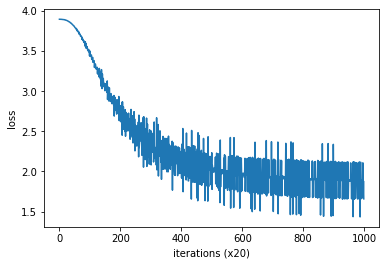

In [25]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [27]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [-1.0322562  -0.92852366 -0.91314006 -1.6433716   0.89264196]
say [-0.01735126  1.1437923   1.1363485  -1.210474   -1.1408434 ]
goodbye [-0.7339345 -1.0594428 -1.0803682  0.6003075  1.0977819]
and [ 1.8630593   0.7818541   0.8925993  -1.2522557  -0.85368955]
i [-0.733266  -1.0264847 -1.0683849  0.6106498  1.0796381]
hello [-1.0157502  -0.94783944 -0.92777944 -1.6570693   0.8853128 ]
. [-1.5913826  1.1553692  1.0612127 -0.6125406 -1.0841907]
